# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

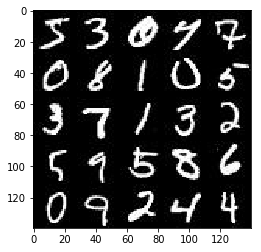

In [2]:
import helper
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

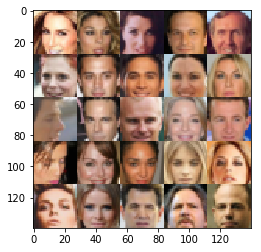

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_dim = image_width*image_height*image_channels
    inputs_real = tf.placeholder(tf.float32,(None,image_width,image_height,image_channels),name='input_real')
    #inputs_real = tf.placeholder(tf.float32,(None,image_width*image_height*image_channels),name='input_real')
    inputs_z    = tf.placeholder(tf.float32,(None,z_dim),name='input_z')
    learning_rate = tf.placeholder(tf.float32,name='learning_rate')  

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Reference
USING architecture implemented in this article - https://towardsdatascience.com/gan-by-example-using-keras-on-tensorflow-backend-1a6d515a60d0

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Functions
    with tf.variable_scope('discriminator',reuse=reuse):
        alpha = 0.2
        # Input layer is 28x28x5
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        print(x1)
        # 16x16x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        print(x2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        print(x3)
        # 4x4x256
        
        x3b = tf.layers.conv2d(relu2, 512, 5, strides=2, padding='same')
        bn3b = tf.layers.batch_normalization(x3b, training=True)
        relu3b = tf.maximum(alpha * bn3b, bn3b)
        # 4x4x256
        print(x3b)

        
        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*512))
        print(flat)
        logits = tf.layers.dense(flat, 1)
        print(logits)
        #return out, logits       
        
    return tf.convert_to_tensor(tf.sigmoid(logits), dtype=tf.float32),tf.convert_to_tensor(logits, dtype=tf.float32)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS L)INE
"""
tests.test_discriminator(discriminator, tf)

Tensor("conv2d/BiasAdd:0", shape=(?, 14, 14, 64), dtype=float32)
Tensor("conv2d_2/BiasAdd:0", shape=(?, 7, 7, 128), dtype=float32)
Tensor("conv2d_3/BiasAdd:0", shape=(?, 4, 4, 256), dtype=float32)
Tensor("conv2d_4/BiasAdd:0", shape=(?, 4, 4, 512), dtype=float32)
Tensor("Reshape:0", shape=(?, 8192), dtype=float32)
Tensor("dense/BiasAdd:0", shape=(?, 1), dtype=float32)
Tensor("conv2d_5/BiasAdd:0", shape=(?, 14, 14, 64), dtype=float32)
Tensor("conv2d_6/BiasAdd:0", shape=(?, 7, 7, 128), dtype=float32)
Tensor("conv2d_7/BiasAdd:0", shape=(?, 4, 4, 256), dtype=float32)
Tensor("conv2d_8/BiasAdd:0", shape=(?, 4, 4, 512), dtype=float32)
Tensor("Reshape_1:0", shape=(?, 8192), dtype=float32)
Tensor("dense_2/BiasAdd:0", shape=(?, 1), dtype=float32)
Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator',reuse= not is_train):
        alpha = 0.2

        #print(out_channel_dim)

        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512,bias_initializer=tf.zeros_initializer())
        print(x1)   
    
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        print(x1)
        # 4x4x512 now

        #x2c = tf.layers.conv2d_transpose(x1, 512, 5, strides=2, padding='same')
        #x2c = tf.layers.batch_normalization(x2c, training=is_train)
        #x2c = tf.maximum(alpha * x2c, x2c)
        #print(x2c)
        
        x2b = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2b = tf.layers.batch_normalization(x2b, training=is_train)
        x2b = tf.maximum(alpha * x2b, x2b)
        #print(x2b)
        

        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        print(x2)
        #print(x2)

        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        print(x3)
        
        x4 = tf.layers.conv2d_transpose(x1, 32, 5, strides=4, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        print(x4)
        
        #print(x3)

        # Output layer
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=1, padding='same')
        print(logits)
        # 28x28x5 now

        out = tf.tanh(logits)
    
    return tf.convert_to_tensor(out, dtype=tf.float32)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tensor("dense/BiasAdd:0", shape=(?, 25088), dtype=float32)
Tensor("Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("Maximum_3:0", shape=(?, 28, 28, 64), dtype=float32)
Tensor("Maximum_4:0", shape=(?, 28, 28, 32), dtype=float32)
Tensor("conv2d_transpose_5/BiasAdd:0", shape=(?, 28, 28, 5), dtype=float32)
Tensor("dense_2/BiasAdd:0", shape=(?, 25088), dtype=float32)
Tensor("Maximum_5:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("Maximum_7:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("Maximum_8:0", shape=(?, 28, 28, 64), dtype=float32)
Tensor("Maximum_9:0", shape=(?, 28, 28, 32), dtype=float32)
Tensor("conv2d_transpose_10/BiasAdd:0", shape=(?, 28, 28, 5), dtype=float32)
Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim,True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    smooth = 0.1

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real)*(1-smooth)))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_real)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tensor("generator/dense/BiasAdd:0", shape=(?, 25088), dtype=float32)
Tensor("generator/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator/Maximum_3:0", shape=(?, 28, 28, 64), dtype=float32)
Tensor("generator/Maximum_4:0", shape=(?, 28, 28, 32), dtype=float32)
Tensor("generator/conv2d_transpose_5/BiasAdd:0", shape=(?, 28, 28, 4), dtype=float32)
Tensor("discriminator/conv2d/BiasAdd:0", shape=(?, 14, 14, 64), dtype=float32)
Tensor("discriminator/conv2d_2/BiasAdd:0", shape=(?, 7, 7, 128), dtype=float32)
Tensor("discriminator/conv2d_3/BiasAdd:0", shape=(?, 4, 4, 256), dtype=float32)
Tensor("discriminator/conv2d_4/BiasAdd:0", shape=(?, 4, 4, 512), dtype=float32)
Tensor("discriminator/Reshape:0", shape=(?, 8192), dtype=float32)
Tensor("discriminator/dense/BiasAdd:0", shape=(?, 1), dtype=float32)
Tensor("discriminator_1/conv2d/BiasAdd:0", shape=(?, 14, 14, 64), dtype=float32)
Tensor("discriminator_1/conv2d_2

### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    #pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
class GAN:
    def __init__(self, real_size, z_size, learning_rate, alpha=0.2, beta1=0.5):
        #tf.reset_default_graph()
        
        #print(real_size.shape)
        
        self.input_real, self.input_z,self.learning_rate = model_inputs(real_size[1], real_size[2],real_size[3],z_size)
        
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z,
                                              real_size[3])
        
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model

    samples, losses = [], []
    steps = 0
    
    # Create the network
    print(data_shape[0])
    print(data_shape[1])
    net = GAN(data_shape, z_dim, learning_rate, alpha=.01, beta1=0.5)
   
    #t_vars = tf.trainable_variables()
    #d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    #g_vars = [var for var in t_vars if var.name.startswith('generator')]  
    
    #saver = tf.train.Saver(var_list=g_vars)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                # Get images, reshape and rescale to pass to D
                #batch_images = batch_images.reshape((batch_size, 784))
                #batch_images = batch_images*2 - 1
                #print(batch_images.shape)

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                #print(batch_images.shape)
                #print(data_shape)
            

                # Run optimizers
                _ = sess.run(net.d_opt, feed_dict={net.input_real: batch_images, net.input_z: batch_z})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: batch_images})

                if epoch_i % 2 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: batch_images})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Epoch {}/{}...".format(steps+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                    
                    
                 #
                
        #saver.save(sess, './checkpoints/generator.ckpt')
        show_generator_output(sess, 25,net.input_z, data_shape[3], data_image_mode);
    #with open('samples.pkl', 'wb') as f:
        #pkl.dump(samples, f)
    



                
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

60000
28
Tensor("generator/dense/BiasAdd:0", shape=(?, 25088), dtype=float32)
Tensor("generator/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator/Maximum_3:0", shape=(?, 28, 28, 64), dtype=float32)
Tensor("generator/Maximum_4:0", shape=(?, 28, 28, 32), dtype=float32)
Tensor("generator/conv2d_transpose_5/BiasAdd:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("discriminator/conv2d/BiasAdd:0", shape=(?, 14, 14, 64), dtype=float32)
Tensor("discriminator/conv2d_2/BiasAdd:0", shape=(?, 7, 7, 128), dtype=float32)
Tensor("discriminator/conv2d_3/BiasAdd:0", shape=(?, 4, 4, 256), dtype=float32)
Tensor("discriminator/conv2d_4/BiasAdd:0", shape=(?, 4, 4, 512), dtype=float32)
Tensor("discriminator/Reshape:0", shape=(?, 8192), dtype=float32)
Tensor("discriminator/dense/BiasAdd:0", shape=(?, 1), dtype=float32)
Tensor("discriminator_1/conv2d/BiasAdd:0", shape=(?, 14, 14, 64), dtype=float32)
Tensor("discriminator_1

Epoch 103/2... Discriminator Loss: 0.8597... Generator Loss: 3.6034
Epoch 104/2... Discriminator Loss: 0.6752... Generator Loss: 1.9274
Epoch 105/2... Discriminator Loss: 0.9705... Generator Loss: 0.9687
Epoch 106/2... Discriminator Loss: 0.8333... Generator Loss: 3.1842
Epoch 107/2... Discriminator Loss: 0.8869... Generator Loss: 1.0913
Epoch 108/2... Discriminator Loss: 0.5919... Generator Loss: 2.7094
Epoch 109/2... Discriminator Loss: 0.7058... Generator Loss: 1.3775
Epoch 110/2... Discriminator Loss: 0.5846... Generator Loss: 3.1833
Epoch 111/2... Discriminator Loss: 0.6031... Generator Loss: 1.7234
Epoch 112/2... Discriminator Loss: 0.4823... Generator Loss: 2.7994
Epoch 113/2... Discriminator Loss: 0.4888... Generator Loss: 2.4246
Epoch 114/2... Discriminator Loss: 0.4935... Generator Loss: 2.3554
Epoch 115/2... Discriminator Loss: 0.5085... Generator Loss: 2.1162
Epoch 116/2... Discriminator Loss: 0.5053... Generator Loss: 3.6792
Epoch 117/2... Discriminator Loss: 1.1428... Gen

Epoch 223/2... Discriminator Loss: 1.3058... Generator Loss: 3.2066
Epoch 224/2... Discriminator Loss: 2.4498... Generator Loss: 0.1624
Epoch 225/2... Discriminator Loss: 1.8631... Generator Loss: 3.4266
Epoch 226/2... Discriminator Loss: 1.0186... Generator Loss: 0.8869
Epoch 227/2... Discriminator Loss: 1.3071... Generator Loss: 0.5911
Epoch 228/2... Discriminator Loss: 1.6380... Generator Loss: 2.7268
Epoch 229/2... Discriminator Loss: 1.6090... Generator Loss: 0.4336
Epoch 230/2... Discriminator Loss: 1.3331... Generator Loss: 1.3219
Epoch 231/2... Discriminator Loss: 1.2033... Generator Loss: 0.8969
Epoch 232/2... Discriminator Loss: 1.0334... Generator Loss: 1.0782
Epoch 233/2... Discriminator Loss: 0.9623... Generator Loss: 1.4682
Epoch 234/2... Discriminator Loss: 0.9969... Generator Loss: 1.0332
Epoch 235/2... Discriminator Loss: 0.9257... Generator Loss: 1.4953
Tensor("generator_1/dense/BiasAdd:0", shape=(?, 25088), dtype=float32)
Tensor("generator_1/Maximum:0", shape=(?, 7, 

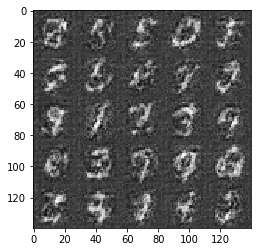

In [13]:
batch_size = 256
z_dim = 100
learning_rate = .001
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

202599
28
Tensor("generator/dense/BiasAdd:0", shape=(?, 25088), dtype=float32)
Tensor("generator/Maximum:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("generator/Maximum_2:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("generator/Maximum_3:0", shape=(?, 28, 28, 64), dtype=float32)
Tensor("generator/Maximum_4:0", shape=(?, 28, 28, 32), dtype=float32)
Tensor("generator/conv2d_transpose_5/BiasAdd:0", shape=(?, 28, 28, 3), dtype=float32)
Tensor("discriminator/conv2d/BiasAdd:0", shape=(?, 14, 14, 64), dtype=float32)
Tensor("discriminator/conv2d_2/BiasAdd:0", shape=(?, 7, 7, 128), dtype=float32)
Tensor("discriminator/conv2d_3/BiasAdd:0", shape=(?, 4, 4, 256), dtype=float32)
Tensor("discriminator/conv2d_4/BiasAdd:0", shape=(?, 4, 4, 512), dtype=float32)
Tensor("discriminator/Reshape:0", shape=(?, 8192), dtype=float32)
Tensor("discriminator/dense/BiasAdd:0", shape=(?, 1), dtype=float32)
Tensor("discriminator_1/conv2d/BiasAdd:0", shape=(?, 14, 14, 64), dtype=float32)
Tensor("discriminator_

Epoch 103/1... Discriminator Loss: 0.7034... Generator Loss: 1.6126
Epoch 104/1... Discriminator Loss: 1.1386... Generator Loss: 8.1793
Epoch 105/1... Discriminator Loss: 2.6699... Generator Loss: 0.3743
Epoch 106/1... Discriminator Loss: 0.7192... Generator Loss: 10.0213
Epoch 107/1... Discriminator Loss: 0.4068... Generator Loss: 5.7237
Epoch 108/1... Discriminator Loss: 0.8174... Generator Loss: 2.0679
Epoch 109/1... Discriminator Loss: 1.6425... Generator Loss: 3.4316
Epoch 110/1... Discriminator Loss: 5.9372... Generator Loss: 0.0152
Epoch 111/1... Discriminator Loss: 5.9486... Generator Loss: 9.8874
Epoch 112/1... Discriminator Loss: 2.4405... Generator Loss: 3.8673
Epoch 113/1... Discriminator Loss: 2.7131... Generator Loss: 0.4043
Epoch 114/1... Discriminator Loss: 1.9074... Generator Loss: 0.5170
Epoch 115/1... Discriminator Loss: 1.6126... Generator Loss: 1.4570
Epoch 116/1... Discriminator Loss: 1.6183... Generator Loss: 0.9742
Epoch 117/1... Discriminator Loss: 1.4738... Ge

Epoch 223/1... Discriminator Loss: 1.3666... Generator Loss: 0.5820
Epoch 224/1... Discriminator Loss: 1.5739... Generator Loss: 1.5107
Epoch 225/1... Discriminator Loss: 1.1989... Generator Loss: 0.7447
Epoch 226/1... Discriminator Loss: 1.0901... Generator Loss: 1.7236
Epoch 227/1... Discriminator Loss: 0.5509... Generator Loss: 2.7097
Epoch 228/1... Discriminator Loss: 1.4824... Generator Loss: 0.6066
Epoch 229/1... Discriminator Loss: 0.7132... Generator Loss: 4.0932
Epoch 230/1... Discriminator Loss: 1.0625... Generator Loss: 0.9711
Epoch 231/1... Discriminator Loss: 0.5331... Generator Loss: 3.7358
Epoch 232/1... Discriminator Loss: 1.8211... Generator Loss: 0.3051
Epoch 233/1... Discriminator Loss: 3.0979... Generator Loss: 6.2476
Epoch 234/1... Discriminator Loss: 1.1751... Generator Loss: 1.6084
Epoch 235/1... Discriminator Loss: 0.8626... Generator Loss: 1.1100
Epoch 236/1... Discriminator Loss: 0.8140... Generator Loss: 1.2089
Epoch 237/1... Discriminator Loss: 2.3716... Gen

Epoch 343/1... Discriminator Loss: 1.0640... Generator Loss: 0.8401
Epoch 344/1... Discriminator Loss: 0.9442... Generator Loss: 2.1806
Epoch 345/1... Discriminator Loss: 0.8569... Generator Loss: 1.0890
Epoch 346/1... Discriminator Loss: 1.4310... Generator Loss: 2.5054
Epoch 347/1... Discriminator Loss: 3.5855... Generator Loss: 0.0799
Epoch 348/1... Discriminator Loss: 4.1314... Generator Loss: 6.1310
Epoch 349/1... Discriminator Loss: 1.0413... Generator Loss: 1.7393
Epoch 350/1... Discriminator Loss: 0.9382... Generator Loss: 0.9638
Epoch 351/1... Discriminator Loss: 0.6190... Generator Loss: 1.6148
Epoch 352/1... Discriminator Loss: 0.7011... Generator Loss: 2.4671
Epoch 353/1... Discriminator Loss: 0.6352... Generator Loss: 1.6824
Epoch 354/1... Discriminator Loss: 1.3768... Generator Loss: 0.5052
Epoch 355/1... Discriminator Loss: 1.7666... Generator Loss: 4.7387
Epoch 356/1... Discriminator Loss: 0.9492... Generator Loss: 1.0752
Epoch 357/1... Discriminator Loss: 0.7547... Gen

Epoch 463/1... Discriminator Loss: 0.3523... Generator Loss: 4.6789
Epoch 464/1... Discriminator Loss: 0.6249... Generator Loss: 1.5259
Epoch 465/1... Discriminator Loss: 0.4233... Generator Loss: 4.0624
Epoch 466/1... Discriminator Loss: 0.4896... Generator Loss: 2.2586
Epoch 467/1... Discriminator Loss: 0.3990... Generator Loss: 5.6057
Epoch 468/1... Discriminator Loss: 0.9255... Generator Loss: 0.9793
Epoch 469/1... Discriminator Loss: 0.5767... Generator Loss: 5.1206
Epoch 470/1... Discriminator Loss: 0.3683... Generator Loss: 4.9788
Epoch 471/1... Discriminator Loss: 0.6766... Generator Loss: 1.6374
Epoch 472/1... Discriminator Loss: 0.4864... Generator Loss: 6.4894
Epoch 473/1... Discriminator Loss: 0.3411... Generator Loss: 6.2794
Epoch 474/1... Discriminator Loss: 0.8524... Generator Loss: 1.0847
Epoch 475/1... Discriminator Loss: 0.6147... Generator Loss: 6.8393
Epoch 476/1... Discriminator Loss: 0.3946... Generator Loss: 3.2528
Epoch 477/1... Discriminator Loss: 0.3649... Gen

Epoch 583/1... Discriminator Loss: 0.4413... Generator Loss: 3.5358
Epoch 584/1... Discriminator Loss: 0.6837... Generator Loss: 1.7676
Epoch 585/1... Discriminator Loss: 0.6400... Generator Loss: 6.5818
Epoch 586/1... Discriminator Loss: 1.0740... Generator Loss: 1.1055
Epoch 587/1... Discriminator Loss: 0.4465... Generator Loss: 4.7803
Epoch 588/1... Discriminator Loss: 0.4723... Generator Loss: 3.4006
Epoch 589/1... Discriminator Loss: 0.3571... Generator Loss: 5.3164
Epoch 590/1... Discriminator Loss: 1.0040... Generator Loss: 1.2987
Epoch 591/1... Discriminator Loss: 2.6755... Generator Loss: 4.1686
Epoch 592/1... Discriminator Loss: 0.9580... Generator Loss: 1.5934
Epoch 593/1... Discriminator Loss: 1.2579... Generator Loss: 2.0605
Epoch 594/1... Discriminator Loss: 0.9457... Generator Loss: 1.0398
Epoch 595/1... Discriminator Loss: 1.2731... Generator Loss: 1.3893
Epoch 596/1... Discriminator Loss: 2.0413... Generator Loss: 0.2515
Epoch 597/1... Discriminator Loss: 1.7224... Gen

Epoch 703/1... Discriminator Loss: 0.3436... Generator Loss: 5.2937
Epoch 704/1... Discriminator Loss: 0.3650... Generator Loss: 3.8628
Epoch 705/1... Discriminator Loss: 0.3742... Generator Loss: 3.5374
Epoch 706/1... Discriminator Loss: 0.3498... Generator Loss: 7.1241
Epoch 707/1... Discriminator Loss: 0.3457... Generator Loss: 5.1252
Epoch 708/1... Discriminator Loss: 0.3893... Generator Loss: 3.2970
Epoch 709/1... Discriminator Loss: 0.3456... Generator Loss: 5.9172
Epoch 710/1... Discriminator Loss: 0.3985... Generator Loss: 3.2958
Epoch 711/1... Discriminator Loss: 0.3337... Generator Loss: 7.0037
Epoch 712/1... Discriminator Loss: 0.3400... Generator Loss: 5.1166
Epoch 713/1... Discriminator Loss: 0.3939... Generator Loss: 3.0233
Epoch 714/1... Discriminator Loss: 0.5619... Generator Loss: 1.8424
Epoch 715/1... Discriminator Loss: 0.8070... Generator Loss: 4.0233
Epoch 716/1... Discriminator Loss: 0.5061... Generator Loss: 3.2379
Epoch 717/1... Discriminator Loss: 0.4394... Gen

Epoch 823/1... Discriminator Loss: 0.5853... Generator Loss: 2.4886
Epoch 824/1... Discriminator Loss: 1.7189... Generator Loss: 0.4480
Epoch 825/1... Discriminator Loss: 1.4462... Generator Loss: 3.5736
Epoch 826/1... Discriminator Loss: 0.4771... Generator Loss: 2.6287
Epoch 827/1... Discriminator Loss: 0.6579... Generator Loss: 1.7199
Epoch 828/1... Discriminator Loss: 0.9183... Generator Loss: 1.0379
Epoch 829/1... Discriminator Loss: 1.1197... Generator Loss: 5.7002
Epoch 830/1... Discriminator Loss: 0.8853... Generator Loss: 1.1830
Epoch 831/1... Discriminator Loss: 0.8050... Generator Loss: 4.2939
Epoch 832/1... Discriminator Loss: 1.0755... Generator Loss: 1.1173
Epoch 833/1... Discriminator Loss: 1.1143... Generator Loss: 0.8876
Epoch 834/1... Discriminator Loss: 2.2359... Generator Loss: 4.7583
Epoch 835/1... Discriminator Loss: 1.2913... Generator Loss: 0.7040
Epoch 836/1... Discriminator Loss: 0.6353... Generator Loss: 2.7187
Epoch 837/1... Discriminator Loss: 0.4336... Gen

Epoch 943/1... Discriminator Loss: 0.4710... Generator Loss: 3.6249
Epoch 944/1... Discriminator Loss: 0.5572... Generator Loss: 1.8270
Epoch 945/1... Discriminator Loss: 0.3481... Generator Loss: 6.5340
Epoch 946/1... Discriminator Loss: 0.3470... Generator Loss: 4.7181
Epoch 947/1... Discriminator Loss: 1.3016... Generator Loss: 0.5411
Epoch 948/1... Discriminator Loss: 2.4967... Generator Loss: 5.2437
Epoch 949/1... Discriminator Loss: 1.0289... Generator Loss: 0.8632
Epoch 950/1... Discriminator Loss: 0.6554... Generator Loss: 2.5814
Epoch 951/1... Discriminator Loss: 1.1174... Generator Loss: 0.7027
Epoch 952/1... Discriminator Loss: 0.9187... Generator Loss: 2.4630
Epoch 953/1... Discriminator Loss: 0.4745... Generator Loss: 2.3464
Epoch 954/1... Discriminator Loss: 1.0623... Generator Loss: 0.7607
Epoch 955/1... Discriminator Loss: 1.3088... Generator Loss: 5.4086
Epoch 956/1... Discriminator Loss: 0.4122... Generator Loss: 4.1913
Epoch 957/1... Discriminator Loss: 0.7712... Gen

Epoch 1062/1... Discriminator Loss: 0.4953... Generator Loss: 4.3150
Epoch 1063/1... Discriminator Loss: 0.7787... Generator Loss: 1.1567
Epoch 1064/1... Discriminator Loss: 0.6729... Generator Loss: 6.2139
Epoch 1065/1... Discriminator Loss: 0.5459... Generator Loss: 1.8184
Epoch 1066/1... Discriminator Loss: 0.3542... Generator Loss: 5.7289
Epoch 1067/1... Discriminator Loss: 0.3614... Generator Loss: 4.1940
Epoch 1068/1... Discriminator Loss: 0.5929... Generator Loss: 1.6237
Epoch 1069/1... Discriminator Loss: 0.4416... Generator Loss: 7.0214
Epoch 1070/1... Discriminator Loss: 0.3444... Generator Loss: 5.5259
Epoch 1071/1... Discriminator Loss: 0.4399... Generator Loss: 2.9908
Epoch 1072/1... Discriminator Loss: 0.4474... Generator Loss: 2.7247
Epoch 1073/1... Discriminator Loss: 0.3670... Generator Loss: 5.3793
Epoch 1074/1... Discriminator Loss: 0.3750... Generator Loss: 3.8241
Epoch 1075/1... Discriminator Loss: 0.4303... Generator Loss: 2.7917
Epoch 1076/1... Discriminator Loss

Epoch 1180/1... Discriminator Loss: 0.7644... Generator Loss: 3.1924
Epoch 1181/1... Discriminator Loss: 1.3406... Generator Loss: 0.5441
Epoch 1182/1... Discriminator Loss: 0.8923... Generator Loss: 4.8649
Epoch 1183/1... Discriminator Loss: 1.2683... Generator Loss: 0.5899
Epoch 1184/1... Discriminator Loss: 0.9591... Generator Loss: 2.6081
Epoch 1185/1... Discriminator Loss: 0.4586... Generator Loss: 3.1208
Epoch 1186/1... Discriminator Loss: 0.5397... Generator Loss: 1.9677
Epoch 1187/1... Discriminator Loss: 1.2401... Generator Loss: 0.6705
Epoch 1188/1... Discriminator Loss: 1.3019... Generator Loss: 5.4667
Epoch 1189/1... Discriminator Loss: 0.4285... Generator Loss: 4.0931
Epoch 1190/1... Discriminator Loss: 1.0459... Generator Loss: 1.0279
Epoch 1191/1... Discriminator Loss: 1.2816... Generator Loss: 2.7928
Epoch 1192/1... Discriminator Loss: 1.5013... Generator Loss: 0.4876
Epoch 1193/1... Discriminator Loss: 2.5034... Generator Loss: 4.0944
Epoch 1194/1... Discriminator Loss

Epoch 1298/1... Discriminator Loss: 1.3248... Generator Loss: 0.5376
Epoch 1299/1... Discriminator Loss: 1.1173... Generator Loss: 4.8375
Epoch 1300/1... Discriminator Loss: 1.3029... Generator Loss: 0.6338
Epoch 1301/1... Discriminator Loss: 0.8502... Generator Loss: 5.0147
Epoch 1302/1... Discriminator Loss: 0.8194... Generator Loss: 1.1431
Epoch 1303/1... Discriminator Loss: 0.3785... Generator Loss: 5.7266
Epoch 1304/1... Discriminator Loss: 0.3834... Generator Loss: 3.7938
Epoch 1305/1... Discriminator Loss: 2.2794... Generator Loss: 0.2101
Epoch 1306/1... Discriminator Loss: 1.5202... Generator Loss: 4.8165
Epoch 1307/1... Discriminator Loss: 0.7942... Generator Loss: 1.7683
Epoch 1308/1... Discriminator Loss: 0.4735... Generator Loss: 4.3917
Epoch 1309/1... Discriminator Loss: 0.8414... Generator Loss: 1.1373
Epoch 1310/1... Discriminator Loss: 0.4592... Generator Loss: 2.4875
Epoch 1311/1... Discriminator Loss: 1.0816... Generator Loss: 0.7231
Epoch 1312/1... Discriminator Loss

Epoch 1416/1... Discriminator Loss: 0.9710... Generator Loss: 1.0124
Epoch 1417/1... Discriminator Loss: 0.5396... Generator Loss: 3.3255
Epoch 1418/1... Discriminator Loss: 0.6835... Generator Loss: 1.7762
Epoch 1419/1... Discriminator Loss: 0.4295... Generator Loss: 4.0836
Epoch 1420/1... Discriminator Loss: 0.7561... Generator Loss: 1.2264
Epoch 1421/1... Discriminator Loss: 0.6707... Generator Loss: 6.1603
Epoch 1422/1... Discriminator Loss: 0.4516... Generator Loss: 2.7358
Epoch 1423/1... Discriminator Loss: 0.5389... Generator Loss: 1.9176
Epoch 1424/1... Discriminator Loss: 1.3822... Generator Loss: 0.5633
Epoch 1425/1... Discriminator Loss: 2.3521... Generator Loss: 2.9546
Epoch 1426/1... Discriminator Loss: 0.8925... Generator Loss: 1.2883
Epoch 1427/1... Discriminator Loss: 0.6627... Generator Loss: 3.9889
Epoch 1428/1... Discriminator Loss: 1.7603... Generator Loss: 0.3802
Epoch 1429/1... Discriminator Loss: 1.1472... Generator Loss: 2.6295
Epoch 1430/1... Discriminator Loss

Epoch 1534/1... Discriminator Loss: 0.6495... Generator Loss: 1.6394
Epoch 1535/1... Discriminator Loss: 0.4630... Generator Loss: 4.4583
Epoch 1536/1... Discriminator Loss: 1.1504... Generator Loss: 0.7423
Epoch 1537/1... Discriminator Loss: 1.3117... Generator Loss: 6.8803
Epoch 1538/1... Discriminator Loss: 0.3989... Generator Loss: 3.2379
Epoch 1539/1... Discriminator Loss: 0.8589... Generator Loss: 1.0764
Epoch 1540/1... Discriminator Loss: 0.9179... Generator Loss: 5.5230
Epoch 1541/1... Discriminator Loss: 0.6310... Generator Loss: 1.7494
Epoch 1542/1... Discriminator Loss: 0.3976... Generator Loss: 3.6509
Epoch 1543/1... Discriminator Loss: 1.2436... Generator Loss: 0.6042
Epoch 1544/1... Discriminator Loss: 1.3894... Generator Loss: 4.6541
Epoch 1545/1... Discriminator Loss: 1.3858... Generator Loss: 0.5004
Epoch 1546/1... Discriminator Loss: 1.1744... Generator Loss: 2.0338
Epoch 1547/1... Discriminator Loss: 0.8673... Generator Loss: 1.1047
Epoch 1548/1... Discriminator Loss

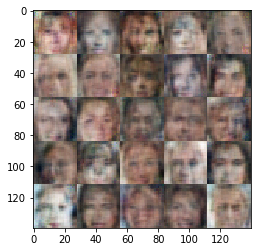

In [14]:
batch_size = 128
z_dim = 100
learning_rate = .001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.